### XGBoost

by Piyush Sanghi

In [50]:
import pandas as pd
from sklearn import model_selection, ensemble, metrics
import seaborn as sns
import xgboost as xgb
import scikitplot as skplt
import matplotlib.pyplot as plt

###### 1. Data Processing

###### a) Import the data from the website directly: https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data (Links to an external site.)Links to an external site.

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', skipinitialspace=True, header=None)

###### b) There is no header included, but information on column names is here: https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names (Links to an external site.)Links to an external site.

In [3]:
df.columns = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'eduction-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'salary'
]

In [4]:
df.head(2)

,age,workclass,fnlwgt,education,eduction-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


###### c) Check your dataframe shape to verify that you have the correct # of rows and columns.

In [5]:
df.shape

(32561, 15)

###### d) Drop the 3rd column from the data (it is referred to as "fnlwgt" on UCI's website and is not necessary in this homework)

In [6]:
df = df.drop(['fnlwgt'], axis=1)
df.head(2)

,age,workclass,education,eduction-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


###### e) Note: There are random values of  '?' that show up in the data - this is fine! These just refer to "unknown" and can be left as is. This data has no true NA values, so no need to check.

###### f) Use the .replace() method to make the following changes to the "salary" column:

 "<=50K" should become 0
">50K" should become 1

In [7]:
df.replace(to_replace=['<=50K', '>50K'], value=[0, 1], inplace=True)

###### g) Create your X dataframe (just your predictors). It should include every feature except for the target variable which is "salary".

In [8]:
X = df.drop(['salary'], axis=1)

In [9]:
X.shape

(32561, 13)

###### h) Create your y dataframe (just your target variable). It should only be "salary".

In [10]:
y = df[['salary']]

In [11]:
y.shape

(32561, 1)

###### i) For this homework we will try converting columns with factors to separate columns (i.e. one-hot encoding). It is not necessary for trees, but can be a very powerful tool to use. There are a variety of ways to do this, but we can use Pandas built-in method .get_dummies(). Pandas will automatically split out columns that are categorical. For now, just run across your full X dataframe.

In [12]:
X_encoded = pd.get_dummies(X)

In [13]:
X_encoded.shape

(32561, 107)

###### j) Split data into train / test set using an 70/30 split. Verify that you have the same number of columns in your X_train and X_test.

In [14]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_encoded, y, test_size=0.3, random_state=10)

In [15]:
(X_train.shape, X_test.shape)

((22792, 107), (9769, 107))

#### 2. Random Forest Classifier - Base Model:

Start by creating a simple Random Forest only using default parameters - this will let us compare Boosting methods to Random Forest in binary classification problems.

###### a) Use the RandomForestClassifier in sklearn. Fit your model on the training data.

In [16]:
model = ensemble.RandomForestClassifier(random_state=10)
model.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

###### b) Use the fitted model to predict on test data. Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes.

In [17]:
y_test_predicted = model.predict(X_test)
y_test_predicted_prob = model.predict_proba(X_test)

###### c) Calculate the confusion matrix and classification report (both are in sklearn.metrics).

In [18]:
def calculate_classification_report_and_confusion_matrix(y_actual, y_predicted):
    #Printing the classification report
    print('-------------  Classification Report  -------------')
    print(metrics.classification_report(y_actual, y_predicted))
    
    print('-------------  Confusion Matrix  -------------')
    
    conf_matrix = metrics.confusion_matrix(y_actual, y_predicted)
    conf_matrix = pd.DataFrame(data=conf_matrix) #converting to dataframe
    
    #Plotting the confusion matrix
    sns.set(font_scale=1.5)
    sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 14}, cmap="YlGnBu", fmt='g')   

-------------  Classification Report  -------------
             precision    recall  f1-score   support

          0       0.88      0.92      0.90      7423
          1       0.70      0.59      0.64      2346

avg / total       0.83      0.84      0.84      9769

-------------  Confusion Matrix  -------------


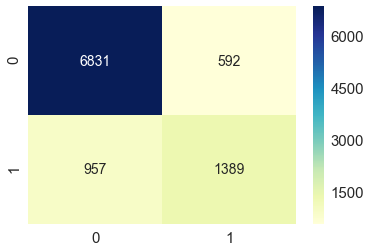

In [19]:
y_test_predicted = pd.DataFrame(data=y_test_predicted, columns=["salary"]) #Converting numpy array to pandas df

calculate_classification_report_and_confusion_matrix(y_test, y_test_predicted)

###### d) Calculate the AUC score (we did this in HW #4 many times).

In [20]:
metrics.roc_auc_score(y_test, y_test_predicted_prob[:, 1])

0.8620777177085711

###### e) Identify the top 5 features. Feel free to print a list OR to make a plot.

In [21]:
features_df = pd.DataFrame(data=list(zip(X_train.columns, model.feature_importances_)), columns=['Feature_Name', 'Importance'])

features_df.sort_values(['Importance'], ascending=False, inplace=True)
features_df.head(5)

,Feature_Name,Importance
0,age,0.231276
4,hours-per-week,0.115297
2,capital-gain,0.093517
1,eduction-num,0.060589
32,marital-status_Married-civ-spouse,0.051410


###### f) Using the model from part B, predict for the train data. Look at the classification report for the train data - is there overfitting for the RandomForest model happening?

In [22]:
y_train_predicted = model.predict(X_train)

-------------  Classification Report  -------------
             precision    recall  f1-score   support

          0       0.97      0.99      0.98     17297
          1       0.96      0.91      0.94      5495

avg / total       0.97      0.97      0.97     22792

-------------  Confusion Matrix  -------------


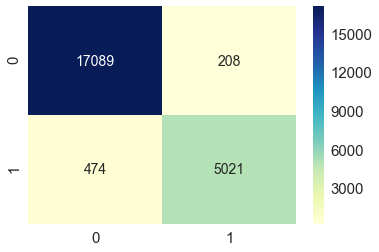

In [23]:
y_train_predicted = pd.DataFrame(data=y_train_predicted, columns=["salary"])

calculate_classification_report_and_confusion_matrix(y_train, y_train_predicted)

We do see signs of over-fitting. The f1-score, precision and recall is very high for train (0.97) when compared with test(0.84).

#### 3. AdaBoost Classifier - GridSearch:

Start by creating a simple AdaBoostClassifier only using default parameters.

###### a) Use the AdaBoostClassifier along with the GridSearchCV tool. Run the GridSearchCV using the following:

n_estimators: 100, 200, 300, 400
learning_rate: 0.2,0.4,0.6,0.8,1, 1.2
Note: Feel free to try out more parameters, the above is the bare minimum for this assignment.

Use 5 cross-fold and for scoring use "roc_auc" (this is the score that will be referenced when identifying the best parameters).

In [24]:
param_grid = {
    'n_estimators' : [100, 200, 300, 400],
    'learning_rate': [0.2, 0.4, 0.6, 0.8, 1, 1.2],
    'random_state': [10]
}

# create AdaBoost model 
ada_model = ensemble.AdaBoostClassifier()

# Create gridsearch object with various combinations of parameters
model_grid_search = model_selection.GridSearchCV(ada_model, param_grid, cv=5, scoring='roc_auc', refit=True, n_jobs=-1, verbose=5)
model_grid_search.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 300, 400], 'learning_rate': [0.2, 0.4, 0.6, 0.8, 1, 1.2], 'random_state': [10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=5)

###### b) Use the best estimator from GridSearchCV to predict on test data. Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes.

In [25]:
best_model = model_grid_search.best_estimator_
print(best_model)

y_test_predicted = best_model.predict(X_test)
y_test_predicted_prob = best_model.predict_proba(X_test)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.2, n_estimators=400, random_state=10)


###### c) Calculate the confusion matrix and classification report (both are in sklearn.metrics).

-------------  Classification Report  -------------
             precision    recall  f1-score   support

          0       0.89      0.94      0.92      7423
          1       0.78      0.64      0.70      2346

avg / total       0.87      0.87      0.87      9769

-------------  Confusion Matrix  -------------


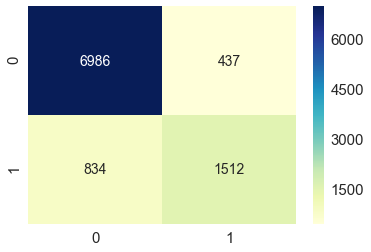

In [26]:
y_test_predicted = pd.DataFrame(data=y_test_predicted, columns=["salary"])

calculate_classification_report_and_confusion_matrix(y_test, y_test_predicted)

###### d) Calculate the AUC score

In [27]:
metrics.roc_auc_score(y_test, y_test_predicted_prob[:, 1])

0.925558352481326

###### e) Identify the top 5 features. Feel free to print a list OR to make a plot.

In [28]:
features_df = pd.DataFrame(data=list(zip(X_train.columns, best_model.feature_importances_)), columns=['Feature_Name', 'Importance'])

features_df.sort_values(['Importance'], ascending=False, inplace=True)
features_df.head(5)

,Feature_Name,Importance
2,capital-gain,0.3850
3,capital-loss,0.2825
0,age,0.0975
4,hours-per-week,0.0500
1,eduction-num,0.0125


###### f) Using the model from part (b), predict for the train data. Look at the classification report for the train data - is there overfitting for the best estimator?

-------------  Classification Report  -------------
             precision    recall  f1-score   support

          0       0.90      0.94      0.92     17297
          1       0.78      0.65      0.71      5495

avg / total       0.87      0.87      0.87     22792

-------------  Confusion Matrix  -------------


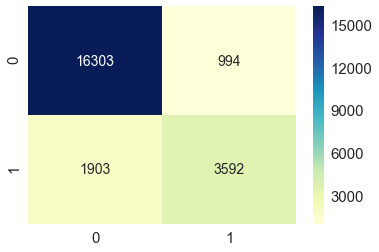

In [29]:
y_train_predicted = best_model.predict(X_train)

y_train_predicted = pd.DataFrame(data=y_train_predicted, columns=["salary"])

calculate_classification_report_and_confusion_matrix(y_train, y_train_predicted)

No. There is no over-fitting for the best estimator using AdaBoost as f1-score, precision and recall scores are steady between train and test

#### 4. Gradient Boosting Classifier - GridSearch:

###### a) Use GradientBoostingClassifier along with the GridSearchCV tool. Run the GridSearchCV using the following hyperparameters:

n_estimators: 100,200, 300 & 400
learning_rate: choose 3 learning rates of your choice
max_depth: 1, 2 (you can try deeper, but remember part of the value of boosting stems from minimal complexity of trees)
Note: Feel free to try out more parameters, the above is the bare minimum for this assignment.

Use 5 cross-fold and for scoring use "roc_auc" (this is the score that will be referenced when identifying the best parameters).

In [30]:
param_grid = {
    'n_estimators' : [100, 200, 300, 400],
    'learning_rate': [0.8, 1, 1.2],
    'max_depth'    : [1, 2],
    'random_state' : [10]
}

# create AdaBoost model 
gradient_boosting_model = ensemble.GradientBoostingClassifier()

# Create gridsearch object with various combinations of parameters
model_grid_search = model_selection.GridSearchCV(gradient_boosting_model, param_grid, cv=5, scoring='roc_auc', refit=True, n_jobs=-1, verbose=5)
model_grid_search.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  4.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 300, 400], 'learning_rate': [0.8, 1, 1.2], 'max_depth': [1, 2], 'random_state': [10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=5)

###### b) Use the best estimator from GridSearchCV to predict on test data. Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes.

In [31]:
best_model = model_grid_search.best_estimator_
print(best_model)

y_test_predicted = best_model.predict(X_test)
y_test_predicted_prob = best_model.predict_proba(X_test)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.8, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=1.0, verbose=0,
              warm_start=False)


###### c) Calculate the confusion matrix and classification report (both are in sklearn.metrics).

-------------  Classification Report  -------------
             precision    recall  f1-score   support

          0       0.89      0.94      0.92      7423
          1       0.77      0.65      0.70      2346

avg / total       0.86      0.87      0.87      9769

-------------  Confusion Matrix  -------------


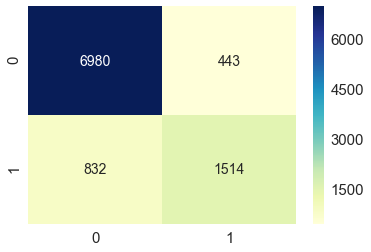

In [32]:
y_test_predicted = pd.DataFrame(data=y_test_predicted, columns=["salary"])

calculate_classification_report_and_confusion_matrix(y_test, y_test_predicted)

###### d) Calculate the AUC score

In [33]:
metrics.roc_auc_score(y_test, y_test_predicted_prob[:, 1])

0.925605296503035

###### e) Identify the top 5 features. Feel free to print a list OR to make a plot.

In [34]:
features_df = pd.DataFrame(data=list(zip(X_train.columns, best_model.feature_importances_)), columns=['Feature_Name', 'Importance'])

features_df.sort_values(['Importance'], ascending=False, inplace=True)
features_df.head(5)

,Feature_Name,Importance
3,capital-loss,0.140007
2,capital-gain,0.106122
0,age,0.080251
32,marital-status_Married-civ-spouse,0.073425
1,eduction-num,0.063623


###### f) Using the model from part (b), predict for the train data. Look at the classification report for the train data - is there overfitting for the best estimator?

-------------  Classification Report  -------------
             precision    recall  f1-score   support

          0       0.90      0.95      0.92     17297
          1       0.80      0.67      0.73      5495

avg / total       0.88      0.88      0.88     22792

-------------  Confusion Matrix  -------------


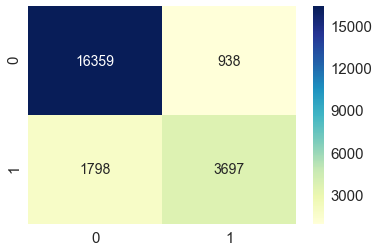

In [35]:
y_train_predicted = best_model.predict(X_train)

y_train_predicted = pd.DataFrame(data=y_train_predicted, columns=["salary"])

calculate_classification_report_and_confusion_matrix(y_train, y_train_predicted)

No. There is no sign of over-fitting for the best estimator using AdaBoost as f1-score, precision and recall scores are steady between train and test

#### 5. XGBoost - RandomizedSearchCV

###### Repeat 4(a) - 4(f) with xgboost and RandomizedSearchCV.

For 4a use the following parameters: 

n_estimators: 100-1000 in increments of 50  (i.e. 100,150,200,.....1000)
learning_rate: 0.1 - 1.6 in increments of 0.1
max_depth: 1, 2
gamma: 0 - 5 in increments of 0.25
Note: For parameters with increments please don't feel the need to type each value by hand. There are better ways to handle this. Post in discussion thread if you are struggling.

For RandomizedSearchCV make sure to still use cv = 5 and for scoring use "roc_auc".

In [36]:
param_grid = {
    'n_estimators' : list(range(100, 1050, 50)),
    'learning_rate': list(map(lambda x: x/100, range(10, 170, 10))),
    'max_depth'    : [1, 2],
    'gamma'        : list(map(lambda x: x/100, range(0, 525, 25))),
    'random_state' : [10]
}

# create AdaBoost model 
xgboost_model = xgb.XGBClassifier()

# Create gridsearch object with various combinations of parameters
model_grid_search = model_selection.RandomizedSearchCV(xgboost_model, param_grid, cv=5, scoring='roc_auc', refit=True, n_jobs=-1, verbose=5)
model_grid_search.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 14.1min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000], 'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6], 'max_depth': [1, 2], 'gamma': [0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0], 'random_state': [10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
      

###### b) Use the best estimator from GridSearchCV to predict on test data. Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes.

In [37]:
best_model = model_grid_search.best_estimator_
print(best_model)

y_test_predicted = best_model.predict(X_test)
y_test_predicted_prob = best_model.predict_proba(X_test)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.5, learning_rate=0.7, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=650,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=10, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


###### c) Calculate the confusion matrix and classification report (both are in sklearn.metrics).

-------------  Classification Report  -------------
             precision    recall  f1-score   support

          0       0.89      0.94      0.92      7423
          1       0.77      0.65      0.70      2346

avg / total       0.87      0.87      0.87      9769

-------------  Confusion Matrix  -------------


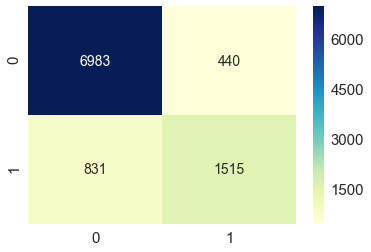

In [38]:
y_test_predicted = pd.DataFrame(data=y_test_predicted, columns=["salary"])

calculate_classification_report_and_confusion_matrix(y_test, y_test_predicted)

##### d) Calculate the AUC score¶

In [39]:
metrics.roc_auc_score(y_test, y_test_predicted_prob[:, 1])

0.9265158956764298

###### e) Identify the top 5 features. Feel free to print a list OR to make a plot.

In [40]:
features_df = pd.DataFrame(data=list(zip(X_train.columns, best_model.feature_importances_)), columns=['Feature_Name', 'Importance'])

features_df.sort_values(['Importance'], ascending=False, inplace=True)
features_df.head(5)

,Feature_Name,Importance
2,capital-gain,0.206434
3,capital-loss,0.150134
0,age,0.123324
4,hours-per-week,0.077748
1,eduction-num,0.050938


###### f) Using the model from part (b), predict for the train data. Look at the classification report for the train data - is there overfitting for the best estimator?

-------------  Classification Report  -------------
             precision    recall  f1-score   support

          0       0.90      0.94      0.92     17297
          1       0.79      0.68      0.73      5495

avg / total       0.88      0.88      0.88     22792

-------------  Confusion Matrix  -------------


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


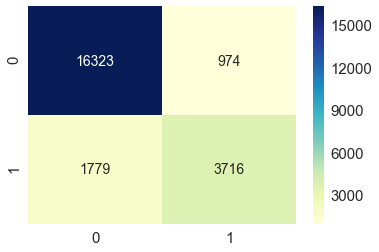

In [41]:
y_train_predicted = best_model.predict(X_train)

y_train_predicted = pd.DataFrame(data=y_train_predicted, columns=["salary"])

calculate_classification_report_and_confusion_matrix(y_train, y_train_predicted)

The x-axis describes how many observations were incorrectly classified as positive when the actual value was negative. i.e in case of medical diagnosis, how many patients were incorrectly diagnosed as having a disease when in actual they didn't.

The y-axis describes how many observations were correctly classified as positive when the actual value was also positive. i.e in case of medical diagnosis, how many patients were correctly diagnosed as having a disease.